In [1]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
%matplotlib inline
import pdb

In [7]:
shape_data=pd.read_csv("/home/hasan/files/shape_data_mean_T").values


In [8]:
shape_data=shape_data[:,1:]
print(shape_data.shape)

(10, 10)


In [13]:
network_dimensions = np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01

normalise_data = True

# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

In [14]:
# establish variables based on data
m = shape_data.shape[0]
n = shape_data.shape[1]
print(m)
# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = shape_data
#print(data)
# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = shape_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = shape_data / data.max()
print(data)

10
[[1.0 0.3333333333333333 0.14285714285714285 0.2857142857142857
  0.5714285714285714 0.2380952380952381 0.619047619047619
  0.6666666666666667 0.8095238095238096 0.5238095238095238]
 [0.3333333333333333 1.0 0.14285714285714285 0.619047619047619
  0.42857142857142855 0.619047619047619 0.2380952380952381
  0.14285714285714285 0.14285714285714285 0.14285714285714285]
 [0.14285714285714285 0.2380952380952381 1.0 0.14285714285714285
  0.3333333333333333 0.14285714285714285 0.19047619047619047
  0.19047619047619047 0.2380952380952381 0.2380952380952381]
 [0.14285714285714285 0.5714285714285714 0.19047619047619047 1.0
  0.5238095238095238 0.5238095238095238 0.14285714285714285
  0.14285714285714285 0.14285714285714285 0.14285714285714285]
 [0.5714285714285714 0.38095238095238093 0.14285714285714285
  0.38095238095238093 1.0 0.14285714285714285 0.6666666666666667
  0.5714285714285714 0.5238095238095238 0.8095238095238096]
 [0.2380952380952381 0.42857142857142855 0.14285714285714285
  0.7619

In [15]:
# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))
print(net)

[[[0.55263294 0.23457539 0.81945213 0.51586246 0.2631777  0.79358369
   0.33145875 0.04708802 0.09001942 0.6402676 ]
  [0.4557075  0.52249182 0.52691132 0.92503557 0.76377675 0.6757096
   0.51212244 0.67229343 0.23794043 0.62316497]
  [0.67897206 0.71040337 0.74140272 0.5380716  0.02737319 0.93605796
   0.75600809 0.22719868 0.78475639 0.73924955]
  [0.86273377 0.33956558 0.83205409 0.55641545 0.61826894 0.14718726
   0.03832713 0.2679562  0.98963555 0.32434341]
  [0.51930514 0.67676801 0.5434103  0.38268159 0.16995083 0.00900285
   0.65810287 0.11225204 0.27466372 0.97876036]]

 [[0.50391504 0.88669374 0.15462279 0.09149903 0.40975295 0.49949145
   0.74463041 0.91629583 0.9930396  0.19469108]
  [0.65259465 0.29558321 0.15616642 0.11144021 0.84716903 0.52465653
   0.05977789 0.52172272 0.83339143 0.31664449]
  [0.76252605 0.99287426 0.85435292 0.64764799 0.90707671 0.05492411
   0.49876649 0.02159964 0.22731101 0.47860963]
  [0.4907494  0.13523709 0.94162665 0.87870035 0.60061811 0.353

In [16]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [17]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [19]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [20]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [22]:
for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    #print("first t value:", t);
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    #print("bmu_index: ",bmu_idx)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            
            #print("net",net)
            #print("wwww:",w)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 10)
                

In [26]:
material_nams=["cuboid","cylinder","handle with bristles","high convexity","long narrow rectangular","medium convexity with handle","rectangular thin with legs","rectangular thin with legs and drawers","small thick rectangular","thin rectangular"]

In [27]:
def find_classification(t, net, m):
  
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [28]:
group = np.zeros(10)
list1 = []
list2 =[]
for i in range(10):
    
    #print('Iteration %d' % i)
    # select a training example at random
    t = data[:, i].reshape(np.array([m, 1]))
    #t = data[:, i].reshape(np.array([m, 1]))
    #print("first t value:", t);
    #print(t)
    # find its Best Matching Unit
    bmu, bmu_idx = find_classification(t, net, m)
    print("bmu_index: ",bmu_idx)
    group[i]=bmu_idx[0]
    list1.append(bmu_idx[0])
    list2.append(bmu_idx[1])
   

bmu_index:  [0 2]
bmu_index:  [3 3]
bmu_index:  [4 0]
bmu_index:  [4 4]
bmu_index:  [1 4]
bmu_index:  [4 2]
bmu_index:  [2 0]
bmu_index:  [2 2]
bmu_index:  [0 3]
bmu_index:  [0 0]


Graph for 5*5 size SOM


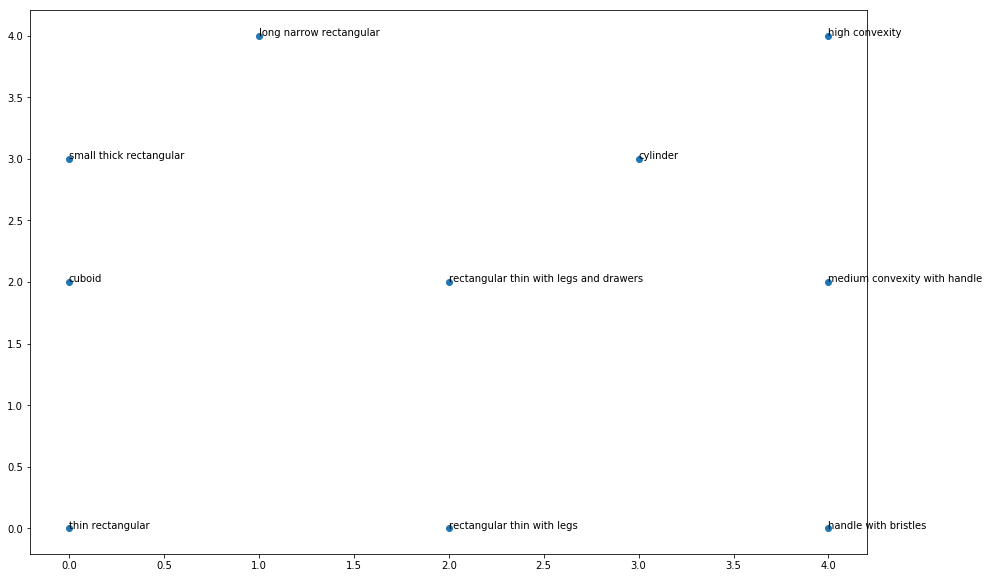

In [30]:
print("Graph for 5*5 size SOM")
    #print(m[1])
    
    #print("m10:",list1[1])
    #plt.text(list1,list2, material_nams[i], ha='center', va='center',
     #    bbox=dict(facecolor='white', alpha=1, lw=0))

f = plt.figure(figsize=(15,10))
ax = f.subplots()
ax.scatter(list1, list2)
    
for i, txt in enumerate(material_nams):
    
    ax.annotate(txt, (list1[i], list2[i]))
    list1[i]+=0.3
    list2[i]+=0.3

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


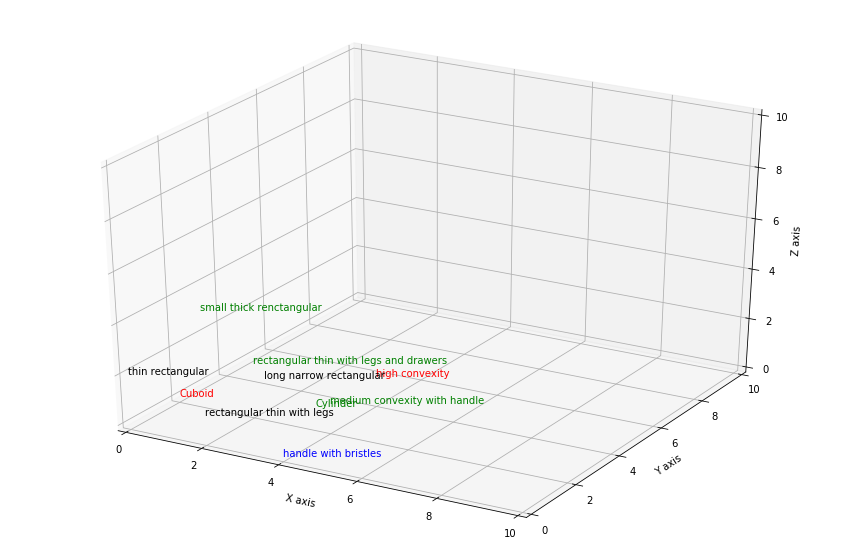

In [33]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


# Demo 2: color
ax.text(0, 2, 0, "Cuboid", color='red')
ax.text(3,3,0, "Cylinder", color="green")
ax.text(4, 0, 0, "handle with bristles", color='blue')
ax.text(4,4,1, "high convexity", color="red")
ax.text(1, 4, 0, "long narrow rectangular", color='black')
ax.text(4,2,1, "medium convexity with handle", color="green")
ax.text(2, 0, 1, "rectangular thin with legs", color='black')
ax.text(2,2,2, "rectangular thin with legs and drawers", color="green")
ax.text(0,3, 3, "small thick renctangular", color='green')
ax.text(0,0,2, "thin rectangular", color="black")



# Demo 3: text2D
# Placement 0, 0 would be the bottom left, 1, 1 would be the top right.


# Tweaking display region and labels
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()